## Probabilistic Matrix Factorization using the MovieLens Dataset

In [1]:
%matplotlib inline
import time

import pandas as pd
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

from numpy.linalg import inv

In [ ]:
# Run this when you haven't created a indexed_ratings.csv yet
# Data: https://www.kaggle.com/rounakbanik/the-movies-dataset/download
#ratings = pd.read_csv('../data/the-movies-dataset/ratings_small.csv')

# Check the minimum number of ratings a user has posted
# print('Minimum number of ratings is ' + str(ratings.groupby('userId').size().min()))

#unique_userId = ratings.userId.unique()
#unique_movieId = ratings.movieId.unique()

#ratings['new_user_index'], ratings['new_movie_index'] = 0, 0

#for old_id, new_id in zip(unique_userId, range(len(unique_userId))):
#    ratings['new_user_index'].iloc[ratings[ratings['userId']==old_id].index.tolist()] = new_id

#for old_id, new_id in zip(unique_movieId, range(len(unique_movieId))):
#    ratings['new_movie_index'].iloc[ratings[ratings['movieId']==old_id].index.tolist()] = new_id
    
#ratings.to_csv('../data/indexed_ratings.csv')

In [2]:
# Run this when you have a indexed_ratings.csv 
ratings = pd.read_csv('../data/indexed_ratings.csv')

In [3]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp,new_user_index,new_movie_index
0,0,1,31,2.5,1260759144,0,0
1,1,1,1029,3.0,1260759179,0,1
2,2,1,1061,3.0,1260759182,0,2
3,3,1,1129,2.0,1260759185,0,3
4,4,1,1172,4.0,1260759205,0,4


In [35]:
# Reference: https://sandipanweb.wordpress.com/2017/04/04/probabilistic-matrix-factorization-with-a-generative-model-in-python/
class PMF:
    def __init__(self, k, prior_mean=0, prior_std=1, epochs=10):
        self.k = k
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.epochs = epochs
        self.u = None
        self.v = None
        
    def fit(self, data):
        ratings = data
        self.I = ratings.userId.nunique()
        self.J = ratings.movieId.nunique()
        self.u = pyro.sample("user_factor", pyro.distributions.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.I,self.k]))
        self.v = pyro.sample("movie_factor", pyro.distributions.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.J,self.k]))
        self.data_var = ratings['rating'].var(axis=0)
        
        user_to_movie_dict = {}
        movie_to_user_dict = {}

        for i in range(self.I):
            user_to_movie_dict[i] = ratings[ratings['new_user_index']==i]['new_movie_index'].tolist()
        for j in range(self.J):
            movie_to_user_dict[j] = ratings[ratings['new_movie_index']==j]['new_user_index'].tolist()
            
        for epoch_num in range(self.epochs):
            # Update of all u_i: Took 110.70313000679016 seconds on Yuki's cp
            for i in range(len(self.u)):
                v_sum = 0
                mv_sum = 0
                for j in user_to_movie_dict[i]:
                    v_sum += np.outer(self.v[j],self.v[j])
                    mv_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.v[j]
                self.u[i] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + v_sum), mv_sum))

            # Update of all v_j: Took 106.21870613098145 seconds on Yuki's cp
            for j in range(len(self.v)):
                u_sum = 0
                mu_sum = 0
                for i in movie_to_user_dict[j]:
                    u_sum += np.outer(self.u[i],self.u[i])
                    mu_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.u[i]
                self.v[j] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + u_sum), mu_sum))

            M_prime = torch.mm(self.u,self.v.T)
            error = 0
            for i in range(len(self.u)):
                for j in user_to_movie_dict[i]:
                    error += (float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) - M_prime[i][j])**2
            print('MSE of Epoch ' + str(epoch_num) + ': ' + str(float(error/len(ratings))))

### Posterior Predictive Check

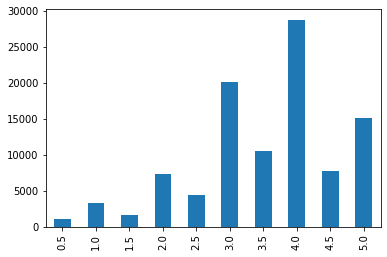

In [27]:
ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

In [38]:
# PPC 
# get distribution of ratings from the entire data, and for each user
# get distribution of ratings from the predicted entire data, and predictions for each user
# check if the discrepancies are close to each other

# Discrepancies of original data
max_rating = max(ratings['rating'])
min_rating = min(ratings['rating'])
mean_rating = ratings['rating'].mean()
median_rating = ratings['rating'].median()
first_q_rating = np.quantile(ratings['rating'],0.25)
third_q_rating = np.quantile(ratings['rating'],0.75)

In [6]:
# POP-PC
# Cross validation POP-PC
# Splitting of train and test data
# Randomly remove ratings from train data, and keep possession of them to check later on 
# Train the model, then compare the entire data distribution and the ratings distributions of each user.

In [36]:
model = PMF(3)

In [37]:
model.fit(ratings)

MSE of Epoch 0: 9.892843246459961
MSE of Epoch 1: 0.9848831295967102
MSE of Epoch 2: 0.8107882738113403
MSE of Epoch 3: 0.7269386649131775
MSE of Epoch 4: 0.6780458688735962
MSE of Epoch 5: 0.6479290127754211
MSE of Epoch 6: 0.6272981762886047
MSE of Epoch 7: 0.6123466491699219
MSE of Epoch 8: 0.6010355949401855
MSE of Epoch 9: 0.5920262336730957
